In [43]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

import setGPU

In [44]:
import tokenizers

In [45]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [46]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [47]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path=None, num_class=None):
        super(TFGPT2Classifier, self).__init__()
        
        self.dir_path = 'gpt2' if dir_path is None else dir_path
        
        self.gpt2 = TFGPT2Model.from_pretrained(self.dir_path)
        self.num_class = self.gpt2.config.num_labels if num_class is None else num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:] 

        return outputs

In [48]:
TOKENIZER_PATH = './gpt_ckpt/kogpt2_news_wiki_ko_cased_818bfa919d.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token='<unused1>',
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [49]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 8
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
MAX_LEN = 39
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"
BASE_MODEL_PATH = './gpt_ckpt'

# Korean Movie Review Classification

In [85]:
# 데이터 전처리 준비

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [51]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [52]:
train_data = train_data[:50] # for test

train_data_sents = list()
train_data_labels = list()

for train_sent, train_label in zip(train_data['document'], train_data['label']):
    tokens = [vocab[vocab.bos_token]]  + vocab[tokenizer(clean_text(train_sent))] + \
             [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = pad_sequences(train_data_sents, MAX_LEN, value=vocab[vocab.padding_token])

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

In [55]:
cls_model = TFGPT2Classifier(BASE_MODEL_PATH)

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [57]:
model_name = "tf2_gpt2_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=5)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

data_out/KORtf2_gpt2_naver_movie -- Folder already exists 

Train on 45 samples, validate on 5 samples
Epoch 1/20
40/45 [=========================>....] - ETA: 3s - loss: 0.7613 - accuracy: 0.5250
Epoch 00001: val_accuracy improved from -inf to 0.20000, saving model to data_out/KORtf2_gpt2_naver_movie/weights.h5
45/45 [==============================] - 29s 649ms/sample - loss: 0.7544 - accuracy: 0.5111 - val_loss: 0.7718 - val_accuracy: 0.2000
Epoch 2/20
40/45 [=========================>....] - ETA: 1s - loss: 0.6601 - accuracy: 0.6000
Epoch 00002: val_accuracy did not improve from 0.20000
45/45 [==============================] - 18s 400ms/sample - loss: 0.6658 - accuracy: 0.6000 - val_loss: 0.9117 - val_accuracy: 0.2000
Epoch 3/20
40/45 [=========================>....] - ETA: 1s - loss: 0.6730 - accuracy: 0.6000
Epoch 00003: val_accuracy did not improve from 0.20000
45/45 [==============================] - 19s 414ms/sample - loss: 0.6720 - accuracy: 0.6000 - val_loss: 0.7627 - val_acc

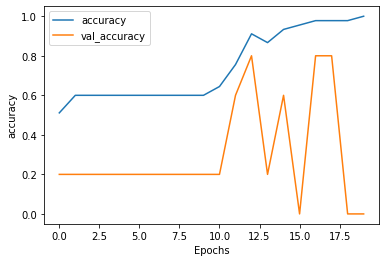

In [58]:
plot_graphs(history, 'accuracy')

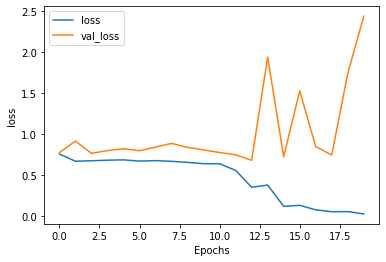

In [59]:
plot_graphs(history, 'loss')

# Korean Movie Review Test 데이터

In [60]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [61]:
test_data = test_data[:50] # for test

test_data_sents = list()
test_data_labels = list()

for test_sent, test_label in zip(test_data['document'], test_data['label']):
    tokens = [vocab[vocab.bos_token]]  + vocab[tokenizer(clean_text(test_sent))] + \
             [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = pad_sequences(test_data_sents, MAX_LEN, value=vocab[vocab.padding_token])#, padding='post')

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [62]:
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))

num sents, labels 50, 50


In [64]:
results = cls_model.evaluate(test_data_sents, test_data_labels)
print("test loss, test acc: ", results)

50/50 [==============================] - 6s 115ms/sample - loss: 2.3543 - accuracy: 0.4800
test loss, test acc:  [2.3543322849273682, 0.48]


# KorNLI 데이터셋 학습

In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
MAX_LEN = 64 

In [65]:
# Load Train dataset
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3).dropna()

In [71]:
train_data_xnli = train_data_xnli[:50] # for test

train_data_sents = list()

for train_sent_1, train_sent_2 in zip(train_data_xnli['sentence1'], train_data_xnli['sentence2']):
    tokens = [vocab[vocab.bos_token]] + vocab[tokenizer(clean_text(train_sent_1))] + \
             [vocab[vocab.eos_token], vocab[vocab.sep_token], vocab[vocab.bos_token]] + \
             vocab[tokenizer(clean_text(train_sent_2))] + [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    train_data_sents.append(tokens)

train_data_sents = pad_sequences(train_data_sents, MAX_LEN, value=vocab[vocab.padding_token])

train_data_sents = np.array(train_data_sents, dtype=np.int64)

In [72]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_xnli["gold_label_int"] = train_data_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(train_data_sents), len(train_data_labels)))

# sents: 50, # labels: 50


In [73]:
sim_model = TFGPT2Classifier('./gpt_ckpt', 3)

In [74]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
sim_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [75]:
model_name = "tf2_gpt_kornli"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=5)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = sim_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE, validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

data_out/KOR/tf2_gpt_kornli -- Folder already exists 

Train on 45 samples, validate on 5 samples
Epoch 1/20
40/45 [=========================>....] - ETA: 3s - loss: 1.1006 - accuracy: 0.4500
Epoch 00001: val_accuracy improved from -inf to 0.40000, saving model to data_out/KOR/tf2_gpt_kornli/weights.h5
45/45 [==============================] - 30s 662ms/sample - loss: 1.1225 - accuracy: 0.4222 - val_loss: 1.0786 - val_accuracy: 0.4000
Epoch 2/20
40/45 [=========================>....] - ETA: 1s - loss: 1.0656 - accuracy: 0.4750
Epoch 00002: val_accuracy did not improve from 0.40000
45/45 [==============================] - 19s 412ms/sample - loss: 1.0706 - accuracy: 0.4444 - val_loss: 1.1005 - val_accuracy: 0.4000
Epoch 3/20
40/45 [=========================>....] - ETA: 1s - loss: 1.0218 - accuracy: 0.6000
Epoch 00003: val_accuracy did not improve from 0.40000
45/45 [==============================] - 18s 405ms/sample - loss: 1.0346 - accuracy: 0.5778 - val_loss: 1.0934 - val_accuracy: 0.4

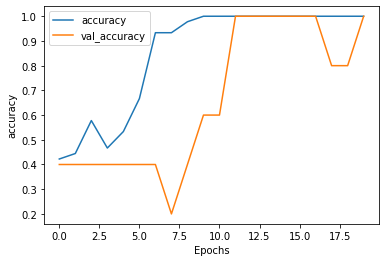

In [76]:
plot_graphs(history, 'accuracy')

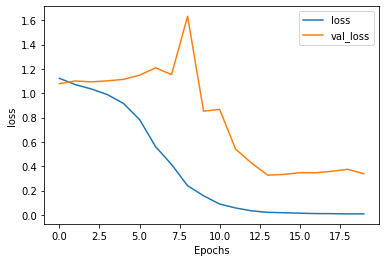

In [77]:
plot_graphs(history, 'loss')

# KorNLI 데이터셋 테스트

In [78]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

In [82]:
# test_data_xnli = test_data_xnli[:50] # for test

test_data_sents = list()

for test_sent_1, test_sent_2 in zip(test_data_xnli['sentence1'], test_data_xnli['sentence2']):
    tokens = [vocab[vocab.bos_token]] + vocab[tokenizer(clean_text(test_sent_1))] + \
             [vocab[vocab.eos_token], vocab[vocab.sep_token], vocab[vocab.bos_token]] + \
             vocab[tokenizer(clean_text(test_sent_2))] + [vocab[vocab.eos_token], vocab[vocab.cls_token]]
    test_data_sents.append(tokens)

test_data_sents = pad_sequences(test_data_sents, MAX_LEN, value=vocab[vocab.padding_token])

test_data_sents = np.array(test_data_sents, dtype=np.int64)

In [83]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_data_sents), len(test_data_labels)))

# sents: 50, # labels: 50


In [84]:
results = sim_model.evaluate(test_data_sents, test_data_labels)
print("test loss, test acc: ", results)

50/50 [==============================] - 6s 117ms/sample - loss: 1.6495 - accuracy: 0.4200
test loss, test acc:  [1.6495202827453612, 0.42]
